In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense

import numpy as np
from scipy import signal

from matplotlib import pyplot as plt
import os
from itertools import product

from mpl_toolkits.mplot3d import Axes3D

parentname = os.path.dirname(os.path.abspath(''))

In [2]:
for i in range(10):
    print((np.array([-.3,-.6,.85])+np.array([.9,.6,.35])*np.random.uniform(-1,1,3)).tolist())

[0.323424069817797, -0.5242241101029715, 1.107706990188643]
[-1.133501772338214, -0.3451492578730858, 0.6308889285792922]
[0.49940903215677795, -0.35688621126924625, 1.1511183579212796]
[-0.09110832490094975, -0.8204924814013306, 1.1801103084911269]
[-0.5409848885447428, -0.5594821253126016, 1.179522623091894]
[-1.1049194450804685, -0.09508875935120387, 0.6122315388749464]
[0.09566063935056801, -0.25487983651822604, 0.7754225633543113]
[-0.6094994968919891, -0.40581575113348944, 1.0045167506537735]
[-0.3788949090348267, -0.18359676770629507, 1.039366727182985]
[0.5949431909551679, -0.7645178974828033, 0.6064194475279143]


In [15]:
r = np.load('S.success_rates.npz')
r1 = np.load('S.min_distances.npz')
print(r['ScratchItch'],r1['ScratchItch'])

[0.638 0.61  0.586 0.406] [0.03290143 0.03193519 0.03265164 0.03836878]


In [3]:
si,f,l,r = np.load('min_distances.npz').values()
print(si,f,l,r)

[0.16512107 0.17055634 0.17327082 0.17531162] [0.16512107 0.17055634 0.17327082 0.17531162] [0.16512107 0.17055634 0.17327082 0.17531162] [0.16512107 0.17055634 0.17327082 0.17531162]


In [11]:
def make_train_LSTM(input_shape,channels=64):
    episode_input = tf.keras.Input(shape=(None,input_shape),name='episode')
    x = LSTM(channels,return_sequences=True,name='lstm1')(episode_input)
    x = LSTM(channels,return_sequences=True,name='lstm2')(x)
    x = LSTM(channels,return_sequences=True,name='lstm3')(x)
    x = LSTM(channels,return_sequences=True,name='lstm4')(x)
    recommendation_pred = Dense(22,name='dense')(x)
    model = tf.keras.Model(inputs=[episode_input],outputs=[recommendation_pred])
    return model

def make_encoder_decoder(obs_shape,channels=64):
    obs_input = tf.keras.Input(shape=(None,obs_shape),name='observation')
    traj_input = tf.keras.Input(shape=(None,3),name='trajectory')
    
    x = LSTM(channels,return_sequences=True,name='encoder1')(obs_input)
#     x = LSTM(channels,return_sequences=True,name='encoder2')(x)
#     x = LSTM(channels,return_sequences=True,name='encoder3')(x)
    x,state_h,state_c = LSTM(channels,return_sequences=True,return_state=True,name='encoder4')(x)
    
    x = LSTM(channels,return_sequences=True,name='decoder1')(traj_input,initial_state=[state_h,state_c])
#     x = LSTM(channels,return_sequences=True,name='decoder2')(x)
#     x = LSTM(channels,return_sequences=True,name='decoder3')(x)
    x = LSTM(channels,return_sequences=True,name='decoder4')(x)
    
    recommendation_pred = Dense(3,name='dense')(x)
    model = tf.keras.Model(inputs=[obs_input,traj_input],outputs=[recommendation_pred])
    return model

def make_pred_LSTM(input_shape,channels=64):
    episode_input = tf.keras.Input(batch_shape=(1,1,input_shape[0]),name='episode')
    x = LSTM(channels,return_sequences=True,stateful=True,name='lstm1')(episode_input)
    x,state_h,state_c = LSTM(channels,stateful=True,return_state=True,name='lstm2')(x)
    recommendation_pred = Dense(3,name='dense')(x)
    model = tf.keras.Model(inputs=[episode_input],outputs=[recommendation_pred,state_c])
    return model

In [12]:
data = np.load(os.path.join(parentname,'samples','processed','f.noised_trajectory.npz'))
data = data['X']

In [13]:
def zlema(period,data):
    lag = (period-1)//2
    data += (data - np.pad(data[:,:-lag,:],((0,0),(lag,0),(0,0))))
    
    alpha = 2/(period+1)
    ema_response = alpha*np.power(1-alpha,range(period))
    ema_response = ema_response.reshape((1,-1,1)).repeat(data.shape[0],axis=0).repeat(data.shape[2],axis=2)
    data = signal.fftconvolve(data,ema_response,mode='same',axes=1)
    return data

def sma(period,data):
    sma_response = np.ones(period)/period
    sma_response = sma_response.reshape((1,-1,1)).repeat(data.shape[0],axis=0).repeat(data.shape[2],axis=2)
    data = signal.fftconvolve(data,sma_response,mode='same',axes=1)
    return data

In [14]:
pred_step = 10
X = data
obs1,obs2 = X[...,:-3],X[:,:X.shape[1]-pred_step,-3:]
target = X[:,pred_step:X.shape[1],-3:]
print(obs1.shape,obs2.shape,target.shape)

(50000, 200, 22) (50000, 190, 3) (50000, 190, 3)


In [15]:
target = (target-np.mean(target,axis=(0,1)))/(np.std(target,axis=(0,1)))
obs1 = (obs1-np.mean(obs1,axis=(0,1)))/(np.std(obs1,axis=(0,1)))
obs2 = (obs2-np.mean(obs2,axis=(0,1)))/(np.std(obs2,axis=(0,1)))

In [16]:
target1 = zlema(20,target)
target2 = sma(20,target)

In [17]:
real_target = data[:,list(range(1,200))+[-1],:3]-data[...,:3]
real_target = (real_target-np.mean(real_target,axis=(0,1)))/np.std(real_target,axis=(0,1))

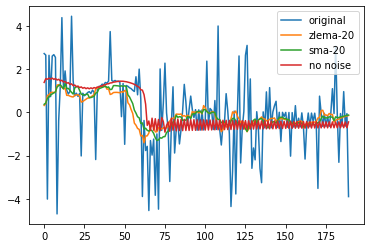

In [20]:
plt.plot(range(190),target[0,:,1],label='original')
plt.plot(range(190),target1[0,:,1],label='zlema-20')
plt.plot(range(190),target2[0,:,1],label='sma-20')
# plt.plot(range(190),target1a[0,:,1],label='zlema-10')
# plt.plot(range(190),target2a[0,:,1],label='sma-10')
plt.plot(range(190),real_target[0,:190,1],label='no noise')
plt.legend()

In [22]:
# model = make_train_LSTM(obs.shape[1:])
model = make_encoder_decoder(22)
model.compile('Adam','mse')
model.fit([obs1,obs2],target2,epochs=20,batch_size=256,validation_split=.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 25s 613us/sample - loss: 0.1616 - val_loss: 0.1420
Epoch 2/20
40000/40000 [==============================] - 7s 184us/sample - loss: 0.1359 - val_loss: 0.1307
Epoch 3/20
40000/40000 [==============================] - 7s 183us/sample - loss: 0.1281 - val_loss: 0.1279
Epoch 4/20
40000/40000 [==============================] - 7s 184us/sample - loss: 0.1234 - val_loss: 0.1235
Epoch 5/20
40000/40000 [==============================] - 7s 187us/sample - loss: 0.1200 - val_loss: 0.1203
Epoch 6/20
40000/40000 [==============================] - 7s 185us/sample - loss: 0.1178 - val_loss: 0.1191
Epoch 7/20
40000/40000 [==============================] - 7s 184us/sample - loss: 0.1161 - val_loss: 0.1189
Epoch 8/20
40000/40000 [==============================] - 7s 183us/sample - loss: 0.1149 - val_loss: 0.1173
Epoch 9/20
40000/40000 [==============================] - 7s 185us/sample - loss: 0.1

In [24]:
model1 = make_encoder_decoder(22)
model1.compile('Adam','mse')
model1.fit([obs1,obs2],target,epochs=10,batch_size=256,validation_split=.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 26s 651us/sample - loss: 4.3650 - val_loss: 4.3199
Epoch 2/10
40000/40000 [==============================] - 7s 186us/sample - loss: 4.2958 - val_loss: 4.2285
Epoch 3/10
40000/40000 [==============================] - 7s 186us/sample - loss: 4.2109 - val_loss: 4.2037
Epoch 4/10
40000/40000 [==============================] - 8s 189us/sample - loss: 4.1910 - val_loss: 4.1878
Epoch 5/10
40000/40000 [==============================] - 8s 188us/sample - loss: 4.1800 - val_loss: 4.1785
Epoch 6/10
40000/40000 [==============================] - 7s 184us/sample - loss: 4.1762 - val_loss: 4.1718
Epoch 7/10
40000/40000 [==============================] - 7s 183us/sample - loss: 4.1605 - val_loss: 4.1561
Epoch 8/10
40000/40000 [==============================] - 8s 188us/sample - loss: 4.1547 - val_loss: 4.1505
Epoch 9/10
40000/40000 [==============================] - 8s 188us/sample - loss: 4.1

In [ ]:
model.save_weights('temp')

(-2.0, 2.0)

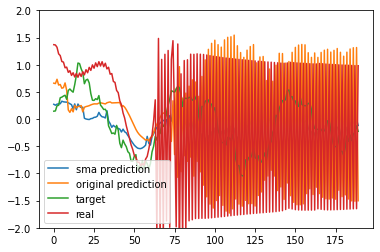

In [25]:
results = model.predict([obs1[[0]],obs2[[0]]])
results1 = model1.predict([obs1[[0]],obs2[[0]]])
plt.plot(range(190),results[0,:,0],label='sma prediction')
plt.plot(range(190),results1[0,:,0],label='original prediction')
plt.plot(range(190),target2[0,:,0],label='target')
plt.plot(range(190),real_target[0,:190,0],label='real')
plt.legend()
plt.ylim(-2,2)

In [ ]:
print(np.linalg.norm(target-np.linalg.norm(target,axis=2)[...,np.newaxis])**2/target.size)

In [ ]:
pred_model = make_pred_LSTM((30,))
pred_model.load_weights('temp')
pred_model.predict(data[0,0][np.newaxis,np.newaxis,:])[0].shape

In [ ]:
test_data = data
results = np.array([pred_model.predict(sample[np.newaxis,np.newaxis,:])[0].flatten() for sample in test_data[0]])

In [ ]:
plt.plot(range(200),results[:,1])